# NER Using 3 Models and Rules-based

In [107]:
# others libraries
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid', palette = 'Set2')

In [4]:
# NLTK and Stanford libraries
import nltk, re, os
import nltk.corpus
from nltk.tokenize import sent_tokenize, word_tokenize, PunktSentenceTokenizer
from nltk.probability import FreqDist
from nltk.tag.stanford import StanfordNERTagger
from nltk import ne_chunk, pos_tag
from nltk.tree import Tree
from nltk import RegexpParser
from nltk.chunk.api import ChunkParserI

In [5]:
# spaCy libraries
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm

## Reading json file and storing in data frame

In [6]:
def read_load(path):
    # reading json file
    with open(path, 'r') as json_file:
        f = json.load(json_file)
    data = f
    
    # Collecting index of word, word, start time, and end time
    df = pd.DataFrame({'indx': ([X for X in range(len(data['values']['word']))]),
                       'word': data['values']['word'], 'start_time': data['values']['start'],
                       'end_time': data['values']['end']})
    
    df = df.set_index('indx')
    
    return data, df

***

# Named Entities Recognition Process

## Stanford NER Tagger

It has 3 models

* 3 classes model for recognizing locations, person, and organizations
* 4 classes model for recognizing locations, person, organizations, and miscellaneous entities
* 7 classes model for recognizing locations, person, organizations, times, money, percents, and dates

In this project, we use 7 classes model

In [7]:
def Stanford_pred(dictt, df):
    
    java_path = ("C:/Program Files/Java/jdk-15.0.1/bin/java.exe")
    os.environ['JAVAHOME'] = java_path
    jar = ('D:/Program/stanford-ner-4.0.0/stanford-ner.jar')
    model = ('D:/Program/stanford-ner-4.0.0/classifiers/english.muc.7class.distsim.crf.ser') # 7 classes
    st = StanfordNERTagger(model, jar, encoding = 'utf-8')
    
    word_token = word_tokenize(dictt)
    classified_text = st.tag(word_token)

    wordlst = []
    ne_lst = []

    for i in range(len(classified_text)):
        if str(classified_text[i][1]) != 'O':
            if str(classified_text[i][1]) == 'PERSON' or str(classified_text[i][1]) == 'LOCATION' or str(classified_text[i][1]) == 'ORGANIZATION' or str(classified_text[i][1]) == 'MONEY' or str(classified_text[i][1]) == 'DATE':
                wordlst.append(str(classified_text[i][0]))
                ne_lst.append(str(classified_text[i][1]))
                
    st_pred = []        
    check = 0  

    for ww in df['word']:
        check = 0
        for w, n in zip(wordlst, ne_lst):
            if ww.__contains__(w):
                check = 1
                st_pred.append(str(n))
                break
        if check == 0:
            st_pred.append('O')
    
    df['stanford_pred'] = st_pred
    
    return st_pred, df

## NLTK

**NLTK recognizes the following entities:**
* ORGANIZATION - Georgia-Pacific Corp., WHO
* PERSON - Eddy Bonte, President Obama
* LOCATION - Murray River, Mount Everest
* DATE - June, 2008-06-29
* TIME - two fifty a m, 1:30 p.m.
* MONEY - 175 million Canadian Dollars, GBP 10.40
* PERCENT - twenty pct, 18.75 %
* FACILITY - Washington Monument, Stonehenge
* GPE - South East Asia, Midlothian

In [8]:
def NLTK_pred(dictt, df):
    
    word_token = word_tokenize(dictt)
    tagged_words = pos_tag(word_token)
    ne_tagged = ne_chunk(tagged_words, binary = False)

    lst_word = []
    lst_ne = []

    for chunk in ne_tagged:
        if hasattr(chunk, 'label'):
            if chunk.label() == 'PERSON' or chunk.label() == 'LOCATION' or chunk.label() == 'ORG' or chunk.label() == 'GPE' or chunk.label() == 'MONEY' or chunk.label() == 'DATE':
                if chunk.label() == 'ORG':
                    lst_word.append(chunk[0][0])
                    lst_ne.append('ORGANIZATION')
                if chunk.label() == 'LOC' or chunk.label() == 'GPE':
                    lst_word.append(chunk[0][0])
                    lst_ne.append('LOCATION')
                else:
                    lst_word.append(chunk[0][0])
                    lst_ne.append(chunk.label())
    
    nltk_pred = []        
    check = 0  

    for ww in df['word']:
        check = 0
        for w, n in zip(lst_word, lst_ne):
            if ww.__contains__(w):
                check = 1
                nltk_pred.append(str(n))
                break
        if check == 0:
            nltk_pred.append('O')
    
    df['nltk_pred'] = nltk_pred
    
    return nltk_pred, df

## spaCy

**spaCy recognizes the following entities:**
* PERSON - People, including fictional.
* NORP - Nationalities or religious or political groups.
* FAC - Buildings, airports, highways, bridges, etc.
* ORG - Companies, agencies, institutions, etc.
* GPE - Countries, cities, states.
* LOC - Non-GPE locations, mountain ranges, bodies of water.
* PRODUCT - Objects, vehicles, foods, etc. (Not services.)
* EVENT - Named hurricanes, battles, wars, sports events, etc.
* WORK_OF_ART - Titles of books, songs, etc.
* LAW - Named documents made into laws.
* LANGUAGE - Any named language.
* DATE - Absolute or relative dates or periods.
* TIME - Times smaller than a day.
* PERCENT - Percentage, including ”%“.
* MONEY - Monetary values, including unit.
* QUANTITY - Measurements, as of weight or distance.
* ORDINAL - “first”, “second”, etc.
* CARDINAL - Numerals that do not fall under another type.

In [9]:
def spaCy_pred(dictt, df):
    
    nlp = en_core_web_sm.load()
    # list of words that have named entities
    text = ([str(X) for X in nlp(dictt)
            if (X.ent_type_ != '' and X.ent_type_ != 'CARDINAL') & (str(X) != 'a') & (str(X) != 'good') & (str(X) != 'day') & (str(X) != '.') & (str(X) != ',')])
    # list of named entities
    ne = ([X.ent_type_ for X in nlp(dictt)
            if (X.ent_type_ != '' and X.ent_type_ != 'CARDINAL') & (str(X) != 'a') & (str(X) != 'good') & (str(X) != 'day') & (str(X) != '.') & (str(X) != ',')])
    
    sp_pred = []
    
    for n, i in enumerate(ne):
        if i == 'LOC':
            ne[n] = 'LOCATION'
        if i == 'GPE':
            ne[n] = 'LOCATION'
        if i == 'ORG':
            ne[n] = 'ORGANIZATION'
          
    check = 0  
    
    for ww in df['word']:
        check = 0
        for w, n in zip(text, ne):
            if ww.__contains__(w):
                check = 1
                sp_pred.append(str(n))
                break
        if check == 0:
            sp_pred.append('O')
                
    df['spacy_pred'] = sp_pred
                
    return sp_pred, df

## Combining Real Named Entities and Regular Expressions

In [25]:
def combined_models(df):
    
    # ------------ Selecting same named entity predictions 2 of 3 models ------------
    
    i_twooth = []
    ne_twooth = []

    for i, st, nl, sp in zip(df.index, df['stanford_pred'], df['nltk_pred'], df['spacy_pred']):
        # check if stanford and nltk are same named entities
        if (st != 'O' and nl != 'O') and (str(st) == str(nl)):
            i_twooth.append(i)
            ne_twooth.append(str(st))
        # check if stanford and spacy are same named entities
        elif (st != 'O' and sp != 'O') and (str(st) == str(sp)):
            i_twooth.append(i)
            ne_twooth.append(str(st))
        # check if nltk and spacy are same named entities
        elif (nl != 'O' and sp != 'O') and (str(nl) == str(sp)):
            i_twooth.append(i)
            ne_twooth.append(str(nl))
        
    combined = []
    combined_check = 0
        
    for i in df.index:
        combined_check = 0
        for ii, n in zip(i_twooth, ne_twooth):
            if i == ii:
                combined_check = 1
                combined.append(str(n))
                break
        if combined_check == 0:
            combined.append('O')
       
    # ------------ Regular Expression checking ------------
    
    pii_index = []
    pii_type = []
    date_check = 0

    for i, num in zip(df.index, df['word']):
        date_check = 0
        for ii in i_twooth:
            if i == ii:
                date_check = 1
                break
        if date_check == 0:
            # ID card e.g. +666-666-666-6666
            if re.search('(\+?[0-9]{3,}-?[0-9]{3,}-?[0-9]{3,}-?[0-9]{4,})', num):
                pii_index.append(i)
                pii_type.append('IDCARD')
            # phone number e.g. 666-666-6666
            elif re.search('(\+?[0-9]{3,}-?[0-9]{3,}-?[0-9]{4,})', num):
                pii_index.append(i)
                pii_type.append('PHONENUM')
            # account number e.g. 666-666-666
            elif re.search('(\+?[0-9]{3,}-?[0-9]{3,}-?[0-9]{3,})', num):
                pii_index.append(i)
                pii_type.append('ACCNUM')
            # card number
            elif re.search('(\+?[0-9]{2,}-?[0-9]{3,}-?[0-9]{3,}-?[0-9]+-?[0-9]+)', num):
                pii_index.append(i)
                pii_type.append('CARDNUM')
            # if not has punctuation
            elif re.search('\+?[0-9]{9,}', num):
                pii_index.append(i)
                pii_type.append('PIINUM')
            
    regex_lst = []
    regex_check = 0
        
    for i in df.index:
        regex_check = 0
        for ii, pi in zip(pii_index, pii_type):
            if i == ii:
                regex_check = 1
                regex_lst.append(str(pi))
                break
        if regex_check == 0:
            regex_lst.append('O')

    # ------------ Combining real ents and regex ------------
            
    cb_rg = []

    for ent, regex in zip(combined, regex_lst):
        if ent != 'O' and regex == 'O':
            cb_rg.append(ent)
        elif regex != 'O' and ent == 'O':
            cb_rg.append(regex)
        else:
            cb_rg.append('O')
            
    df['real_ents'] = cb_rg
    
    return cb_rg, df

## Creating New Data Frame to Store Real Entities

In [14]:
def filter_ents(df):
    
    formal_ents = df.drop(['stanford_pred', 'nltk_pred', 'spacy_pred'], axis = 1)
    formal_ents = formal_ents[formal_ents['real_ents'] != 'O']
    
    return formal_ents

***

## Models Evaluation
**Accuracies of all models**

In [117]:
from nltk.metrics.scores import accuracy

def acc_all(ref, st, nl, sp, re):
    
    st_acc = accuracy(ref, st)
    nltk_acc = accuracy(ref, nl)
    spacy_acc = accuracy(ref, sp)
    r_ent_acc = accuracy(ref, re)
    
    print('\n------------------------------------- Overall Accuracies -------------------------------------------\n')
    print('Stanford Accuracy: %.2f' % (st_acc * 100) + '%')
    print('NLTK Accuracy: %.2f' % (nltk_acc * 100) + '%')
    print('spaCy Accuracy: %.2f' % (spacy_acc * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (r_ent_acc * 100) + '% **')
    print('\n----------------------------------------------------------------------------------------------------\n')
    
    return st_acc, nltk_acc, spacy_acc, r_ent_acc

**Specific named entities accuracies evaluation**

In [11]:
def only_ENT(ent):
    
    person = []
    org = []
    loc = []
    date = []
    money = []
    pii_num = []
    
    for p in ent:
        if p != 'PERSON':
            person.append('O')
        else:
            person.append(str(p))
            
    for o in ent:
        if o != 'ORGANIZATION':
            org.append('O')
        else:
            org.append(str(o))
            
    for l in ent:
        if l != 'LOCATION':
            loc.append('O')
        else:
            loc.append(str(l))
            
    for d in ent:
        if d != 'DATE':
            date.append('O')
        else:
            date.append(str(d))
            
    for m in ent:
        if m != 'MONEY':
            money.append('O')
        else:
            money.append(str(m))
            
    for pi in ent:
        if pi != 'IDCARD' and pi != 'PHONENUM' and pi != 'ACCNUM' and pi != 'PIINUM':
            pii_num.append('O')
        else:
            pii_num.append(str(pi))
            
    return person, org, loc, date, money, pii_num

In [98]:
def acc_each_ENT(r_ps, r_org, r_loc, r_date, r_money, r_num, st_ps, st_org, st_loc, st_date, st_money, st_num, nltk_ps, nltk_org, nltk_loc, nltk_date, nltk_money, nltk_num, sp_ps, sp_org, sp_loc, sp_date, sp_money, sp_num, re_ps, re_org, re_loc, re_date, re_money, re_num):
    
    print('\n-------------------------------- PERSON Prediction Accuracies --------------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_ps, st_ps) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_ps, nltk_ps) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_ps, sp_ps) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_ps, re_ps) * 100) + '% **')

    print('\n----------------------------- ORGANIZATION Prediction Accuracies -----------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_org, st_org) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_org, nltk_org) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_org, sp_org) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_org, re_org) * 100) + '% **')

    print('\n------------------------------- LOCATION Prediction accuracies -------------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_loc, st_loc) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_loc, nltk_loc) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_loc, sp_loc) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_loc, re_loc) * 100) + '% **')

    print('\n--------------------------------- DATE Prediction accuracies ---------------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_date, st_date) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_date, nltk_date) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_date, sp_date) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_date, re_date) * 100) + '% **')

    print('\n--------------------------------- MONEY Prediction accuracies -------------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_money, st_money) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_money, nltk_money) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_money, sp_money) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_money, re_money) * 100) + '% **')
    
    print('\n------------------------------ PII NUMBER Prediction accuracies -----------------------------------\n')
    print('Stanford Accuracy: %.2f' % (accuracy(r_num, st_num) * 100) + '%')
    print('NLTK Accuracy: %.2f' % (accuracy(r_num, nltk_num) * 100) + '%')
    print('spaCy Accuracy: %.2f' % (accuracy(r_num, sp_num) * 100) + '%')
    print('\n** Combined Models and using Regular Expressions Accuracy: %.2f' % (accuracy(r_num, re_num) * 100) + '% **')
    print('\n---------------------------------------------------------------------------------------------------\n')

In [137]:
# Accuracies plot
def acc_plot(st_acc, nltk_acc, spacy_acc, r_ent_acc):
    
    plt.figure(figsize = (8, 5))
    plt.style.use('dark_background')
    sns.barplot(x = ['Stanford', 'NLTK', 'spaCy', 'Combined'], y = [(st_acc * 100), (nltk_acc * 100), (spacy_acc * 100), (r_ent_acc * 100)])
    plt.xlabel('Models')
    plt.ylabel('Accuracies (%)')
    plt.title('Overall Accuracies', fontsize = 14)
    plt.show()
    

***

## Testing more datasets

#### Conversation 2

In [31]:
# Reading json file and storing in df
con2, df2 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_2.json')

# Stanford named entities prediction
st_pred2, df2 = Stanford_pred(con2['transcript'], df2)
# NLTK named entities prediction
nltk_pred2, df2 = NLTK_pred(con2['transcript'], df2)
# spaCy named entities prediction
sp_pred2, df2 = spaCy_pred(con2['transcript'], df2)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg2, df2 = combined_models(df2)
# Filtering the words that only have named entities
formal_ents2 = filter_ents(df2)

In [33]:
# formal_ents2.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con2.csv')

In [53]:
# df2.to_csv('D:/DSBA/Project/Final-Project-2/data/ref_ne_con/ref_con2.csv')


------------------------------------- Overall Accuracies -------------------------------------------

Stanford Accuracy: 88.17%
NLTK Accuracy: 84.62%
spaCy Accuracy: 94.67%

** Combined Models and using Regular Expressions Accuracy: 97.04% **

----------------------------------------------------------------------------------------------------



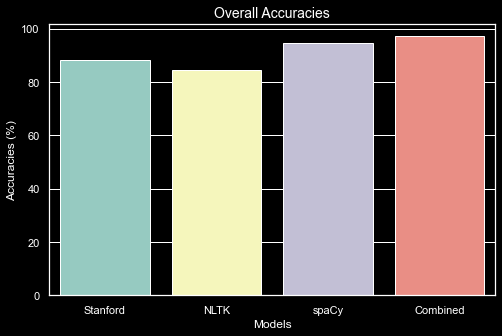

In [138]:
ref2 = pd.read_csv('D:/DSBA/Project/Final-Project-2/data/ref_ne_con/ref_con2.csv')
ref2 = [i for i in ref2['label']]

# Overall accuracies
st2_acc, nltk2_acc, spacy2_acc, r_ent2_acc = acc_all(ref2, st_pred2, nltk_pred2, sp_pred2, cb_rg2)
# Accuracies plot
acc_plot(st2_acc, nltk2_acc, spacy2_acc, r_ent2_acc)

In [120]:
r_ps2, r_org2, r_loc2, r_date2, r_money2, r_num2 = only_ENT(ref2)
st_ps2, st_org2, st_loc2, st_date2, st_money2, st_num2 = only_ENT(st_pred2)
nltk_ps2, nltk_org2, nltk_loc2, nltk_date2, nltk_money2, nltk_num2 = only_ENT(nltk_pred2)
sp_ps2, sp_org2, sp_loc2, sp_date2, sp_money2, sp_num2 = only_ENT(sp_pred2)
re_ps2, re_org2, re_loc2, re_date2, re_money2, re_num2 = only_ENT(cb_rg2)

acc_each_ENT(r_ps2, r_org2, r_loc2, r_date2, r_money2, r_num2, st_ps2, st_org2, st_loc2, st_date2, st_money2, st_num2, nltk_ps2, nltk_org2, nltk_loc2, nltk_date2, nltk_money2, nltk_num2, sp_ps2, sp_org2, sp_loc2, sp_date2, sp_money2, sp_num2, re_ps2, re_org2, re_loc2, re_date2, re_money2, re_num2)


-------------------------------- PERSON Prediction Accuracies --------------------------------------

Stanford Accuracy: 98.82%
NLTK Accuracy: 93.49%
spaCy Accuracy: 100.00%

** Combined Models and using Regular Expressions Accuracy: 100.00% **

----------------------------- ORGANIZATION Prediction Accuracies -----------------------------------

Stanford Accuracy: 99.41%
NLTK Accuracy: 100.00%
spaCy Accuracy: 99.41%

** Combined Models and using Regular Expressions Accuracy: 99.41% **

------------------------------- LOCATION Prediction accuracies -------------------------------------

Stanford Accuracy: 98.82%
NLTK Accuracy: 99.41%
spaCy Accuracy: 100.00%

** Combined Models and using Regular Expressions Accuracy: 100.00% **

--------------------------------- DATE Prediction accuracies ---------------------------------------

Stanford Accuracy: 94.67%
NLTK Accuracy: 96.45%
spaCy Accuracy: 100.00%

** Combined Models and using Regular Expressions Accuracy: 100.00% **

----------------

#### Conversation 3

In [34]:
# Reading json file and storing in df
con3, df3 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_3.json')

# Stanford named entities prediction
st_pred3, df3 = Stanford_pred(con3['transcript'], df3)
# NLTK named entities prediction
nltk_pred3, df3 = NLTK_pred(con3['transcript'], df3)
# spaCy named entities prediction
sp_pred3, df3 = spaCy_pred(con3['transcript'], df3)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg3, df3 = combined_models(df3)
# Filtering the words that only have named entities
formal_ents3 = filter_ents(df3)

In [36]:
formal_ents3.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con3.csv')

#### Conversation 15

In [37]:
# Reading json file and storing in df
con15, df15 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_15.json')

# Stanford named entities prediction
st_pred15, df15 = Stanford_pred(con15['transcript'], df15)
# NLTK named entities prediction
nltk_pred15, df15 = NLTK_pred(con15['transcript'], df15)
# spaCy named entities prediction
sp_pred15, df15 = spaCy_pred(con15['transcript'], df15)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg15, df15 = combined_models(df15)
# Filtering the words that only have named entities
formal_ents15 = filter_ents(df15)

In [39]:
formal_ents15.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con15.csv')

#### Conversation 18

In [22]:
# Reading json file and storing in df
con18, df18 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_18.json')

# Stanford named entities prediction
st_pred18, df18 = Stanford_pred(con18['transcript'], df18)
# NLTK named entities prediction
nltk_pred18, df18 = NLTK_pred(con18['transcript'], df18)
# spaCy named entities prediction
sp_pred18, df18 = spaCy_pred(con18['transcript'], df18)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg18, df18 = combined_models(df18)
# Filtering the words that only have named entities
formal_ents18 = filter_ents(df18)

In [30]:
formal_ents18.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con18.csv')

#### Conversation 20

In [44]:
# Reading json file and storing in df
con20, df20 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_20.json')

# Stanford named entities prediction
st_pred20, df20 = Stanford_pred(con20['transcript'], df20)
# NLTK named entities prediction
nltk_pred20, df20 = NLTK_pred(con20['transcript'], df20)
# spaCy named entities prediction
sp_pred20, df20 = spaCy_pred(con20['transcript'], df20)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg20, df20 = combined_models(df20)
# Filtering the words that only have named entities
formal_ents20 = filter_ents(df20)

In [45]:
formal_ents20.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con20.csv')

#### Conversation 21

In [46]:
# Reading json file and storing in df
con21, df21 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_21.json')

# Stanford named entities prediction
st_pred21, df21 = Stanford_pred(con21['transcript'], df21)
# NLTK named entities prediction
nltk_pred21, df21 = NLTK_pred(con21['transcript'], df21)
# spaCy named entities prediction
sp_pred21, df21 = spaCy_pred(con21['transcript'], df21)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg21, df21 = combined_models(df21)
# Filtering the words that only have named entities
formal_ents21 = filter_ents(df21)

In [48]:
formal_ents21.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con21.csv')

#### Conversation 22

In [49]:
# Reading json file and storing in df
con22, df22 = read_load('D:/DSBA/Project/Final-Project-2/data/GG_Speech/conversation_22.json')

# Stanford named entities prediction
st_pred22, df22 = Stanford_pred(con22['transcript'], df22)
# NLTK named entities prediction
nltk_pred22, df22 = NLTK_pred(con22['transcript'], df22)
# spaCy named entities prediction
sp_pred22, df22 = spaCy_pred(con22['transcript'], df22)
# Selecting same entities (2 of 3 models) and regular expressions (if they're pii num)
cb_rg22, df22 = combined_models(df22)
# Filtering the words that only have named entities
formal_ents22 = filter_ents(df22)

In [51]:
formal_ents22.to_csv('D:/DSBA/Project/Final-Project-2/data/ner_pred/ner_pred_con22.csv')